In [1]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from typing import Callable, Optional
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import torch.nn.functional as F
import pandas as pd
import numpy as np
from celluloid import Camera
from thinker.actor_net import DRCNet
import os
import random
from thinker.actor_net import sample
from actpatchdrc import ActPatchDRCNet
import ast
from captum.attr import IntegratedGradients
import seaborn as sns

/home/tom/mlmi/dissertation/working_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-04 14:00:01,964	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



In [2]:
class ProbingDataset(Dataset):
    def __init__(self, data: list):
        self.data = data
    def __len__(self) -> int:
        return len(self.data)
    def __getitem__(self, index: int) -> dict:
        return self.data[index]
    def get_feature_range(self, feature: str) -> tuple[int, int]:
        assert feature in self.data[0].keys(), f"Please enter a feature in dataset: {self.data[0].keys()}"
        min_feature_value, max_feature_value = self.data[0][feature], self.data[0][feature]
        for entry in self.data:
            if entry[feature] > max_feature_value:
                max_feature_value = entry[feature]
            elif entry[feature] < min_feature_value:
                min_feature_value = entry[feature]
        return (min_feature_value, max_feature_value)


class ProbingDatasetCleaned(Dataset):
    def __init__(self, data: list):
        self.data = data
    def __len__(self) -> int:
        return len(self.data)
    def __getitem__(self, index: int) -> tuple:
        return self.data[index]

In [89]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
envname = f"compare_cutoffpush_0"

env = thinker.make(
    f"Sokoban-cutoffpush_corrupt_0000-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset()
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
#actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state_corrupt = state

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


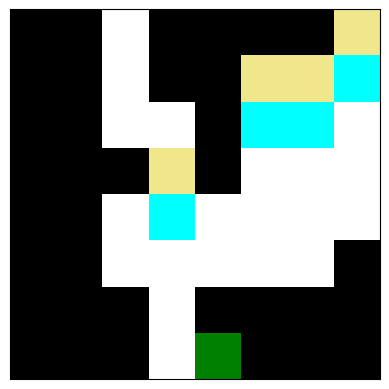

In [90]:
viz.plot_mini_sokoban(state_corrupt["real_states"][0])

In [91]:
_, _ = drc_net(env_out, rnn_state, greedy=True)
layer2_tick1 = drc_net.hidden_state[:,2,160:192,:,:].clone().detach()
layer1_tick2 = drc_net.hidden_state[:,3,96:128,:,:].clone().detach()

In [3]:
class ActPatchDRCNet:
    """
    Wrapper around DRCNet to patch in activations for different runs.
    """

    def __init__(self, drc_net, debug=False):
        self.drc_net = drc_net
        self.debug= debug

    def forward_normal(self, env_out, rnn_state):
        return self.drc_net(env_out, rnn_state)
    
    def forward_patch(self, env_out, rnn_state: tuple, greedy: bool = True, activ_type: Optional[str] = None, patch_dict: Optional[dict] = None, activs: Optional[torch.tensor] = None):
        """Run forward pass of wrapped DRCNet whilst patching in activations from activs

        Args:
            env_out (EnvOut): EnvOut object representing current state of environment
            rnn_state (tuple): current state of ConvLSTM - 2 tensors for each layer (e.g. h_t and c_t)
            greedy (bool, optional): whether to sample actions greedily. Defaults to True.
            activ_type (Optional[str], optional): an optional string that determines where to patching activations into - must be 'xenc', 'cell', 'hidden'- that is set to None if no patching is to occur. Defaults to None.
            patch_dict (Optional[dict], optional): a dictionary containing the channels to patch for the active_Type (hidden, cell, xenc) each layer e.g. if activ_type="hidden", to patch the first two channels of the hidden state for the first two layers {0: [0,1,] 1: [0,1]} . Defaults to None.
            activ_ticks (Optional[list], optional): list of ticks to patch over - if patching, must not be None. Defaults to None.
            activs (Optional[torch.tensor], optional): tensor of activations to patch in. Defaults to None.

        Returns:
            tuple: a tuple of (selected_action, action_probs, action_logits, updated_rnn_state)
        """
        
        activ_layers = list(patch_dict.keys())
        activ_ticks = []
        for patch_entry in patch_dict.values():
            activ_ticks += patch_entry[0]
        activ_ticks = list(set(activ_ticks))
        #print(activ_ticks)

        done = env_out.done
        T = done.shape[0]
        B = activs.shape[0]
        x = self.drc_net.normalize(env_out.real_states.float())
        x = torch.cat([x]*B, dim=0)
        x = torch.flatten(x, 0, 1)
        x_enc = self.drc_net.encoder(x)
        core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))
        assert len(core_input.shape) == 5
        core_output_list = []
        reset = torch.cat([done]*B, dim=1).float()
        if self.drc_net.record_state: 
            self.drc_net.core.hidden_state = []
            self.drc_net.core.hidden_state.append(torch.cat([torch.concat(rnn_state, dim=1)]*B, dim=0)) 
        for n, (x_single, reset_single) in enumerate(
            zip(core_input.unbind(), reset.unbind())
        ):
            for t in range(self.drc_net.core.tran_t):

                if t > 0:
                    reset_single = torch.zeros_like(reset_single)
                reset_single = reset_single.view(-1)
                if activ_type is not None:
                    if t in activ_ticks and (0 in activ_layers or 1 in activ_layers or 2 in activ_layers):
                        if self.debug:
                            print(f"----- patching activations for tick {t} ---- ")
                        output, rnn_state = self.forward_single_patch(
                            x=x_single,
                            core_state=rnn_state,
                            reset=reset_single,
                            activ_type=activ_type, 
                            patch_dict=patch_dict,
                            activs=activs[:,t,:,:,:],
                            current_tick=t
                        )
                    else:
                         output, rnn_state = self.drc_net.core.forward_single(
                            x_single, rnn_state, reset_single, reset_single
                        )
                else:
                    output, rnn_state = self.drc_net.core.forward_single(
                        x_single, rnn_state, reset_single, reset_single
                    )

                if self.drc_net.record_state: self.drc_net.core.hidden_state.append(torch.concat(rnn_state, dim=1))  

            core_output_list.append(output)

        core_output = torch.cat(core_output_list)
        if self.drc_net.record_state: 
           self.drc_net.core.hidden_state = torch.stack(self.drc_net.core.hidden_state, dim=1) # temp change to ensure compatability with integrated gradients in Captum - just store the first batch

        core_output = torch.flatten(core_output, 0, 1)

        if activ_type == "xenc" and 3 in activ_layers and 2 in activ_ticks:
            if self.debug:
                print(f"--- Patching Layer 3 ---")
                print(f"patching channels {patch_channels} in xenc")
            patch_channels = patch_dict[3]
            x_enc[:,patch_channels,:,:] = activs[:,-1,[192+c for c in patch_channels],:,:]

        core_output = torch.cat([x_enc, core_output], dim=1)

        core_output = torch.flatten(core_output, 1)
        final_out = torch.nn.functional.relu(self.drc_net.final_layer(core_output))
        pri_logits = self.drc_net.policy(final_out)
        pri_logits = pri_logits.view(T*B, self.drc_net.dim_actions, self.drc_net.num_actions)
        pri_probs = torch.nn.functional.softmax(pri_logits.view(-1), dim=0)
        pri = sample(pri_logits, greedy=greedy, dim=-1)
        pri = pri.view(T, B, self.drc_net.dim_actions) 
        pri_env = pri[-1, :, 0] if not self.drc_net.tuple_action else pri[-1]   
        action = pri_env
        return (action, pri_probs, pri_logits.view(-1), rnn_state)
    
    def forward_single_patch(self, x, core_state, reset, activ_type=None, patch_dict={}, activs=None, current_tick=0):
        reset = reset.float()

        activ_layers = list(patch_dict.keys())

        b, c, h, w = x.shape
        layer_n = 2
        out = core_state[(self.drc_net.core.num_layers - 1) * layer_n] * (1 - reset).view(
            b, 1, 1, 1
        )  # h_cur on last layer

        core_out = []
        new_core_state = []
        for n, cell in enumerate(self.drc_net.core.layers):
            cell_input = torch.concat([x, out], dim=1)
            h_cur = core_state[n * layer_n + 0] * (1 - reset.view(b, 1, 1, 1))
            c_cur = core_state[n * layer_n + 1] * (1 - reset.view(b, 1, 1, 1))

            layer_patch_ticks = patch_dict[n][0]
        
            if n in activ_layers and activ_type is not None and current_tick in layer_patch_ticks:
                if self.debug:
                    print(f"--- Patching Layer {n} ---")
                patch_channels = patch_dict[n][1]
                if activ_type == "xenc":
                    patch_activs = activs[:,[192+c for c in patch_channels],:,:]
                elif activ_type == "hidden":
                    patch_activs = activs[:,[64*n+c for c in patch_channels],:,:]
                elif activ_type == "cell":
                    patch_activs = activs[:,[64*n+32+c for c in patch_channels],:,:]

                if activ_type == "xenc" and n in activ_layers:
                    if self.debug:
                        print(f"patching channels {patch_channels} in xenc")
                    cell_input[:,patch_channels,:,:] = patch_activs

                h_next, c_next = self.forward_cell_patch(
                    convlstm_cell=cell,
                    input=cell_input,
                    h_cur=h_cur,
                    c_cur=c_cur,
                    activ_type=activ_type,
                    patch_channels=patch_channels, 
                    patch_activs=patch_activs
                )
            else:
                if self.debug:
                    print(f"--- NOT patching layer {n} ---")
                h_next, c_next, _, _ = cell(
                    cell_input, h_cur, c_cur, None, None, None
                )
            if self.drc_net.core.grad_scale < 1 and h_next.requires_grad:
                h_next.register_hook(lambda grad: grad * self.drc_net.core.grad_scale)
                c_next.register_hook(lambda grad: grad * self.drc_net.core.grad_scale)
            new_core_state.append(h_next)
            new_core_state.append(c_next)
            out = h_next

        core_state = tuple(new_core_state)
        core_out = out.unsqueeze(0)
        return core_out, core_state
    
    def forward_cell_patch(self, convlstm_cell, input, h_cur, c_cur, activ_type=None, patch_channels=[], patch_activs=None):

        combined = torch.cat([input, h_cur], dim=1)  
        if convlstm_cell.pool_inject:
            combined = torch.cat(
                [combined, convlstm_cell.proj_max_mean(h_cur)], dim=1
            )  # concatenate along channel axis

        if convlstm_cell.linear:
            combined_conv = convlstm_cell.main(combined[:, :, 0, 0]).unsqueeze(-1).unsqueeze(-1)
        else:
            combined_conv = convlstm_cell.main(combined)

        cc_i, cc_f, cc_o, cc_g, _ = torch.split(combined_conv, convlstm_cell.embed_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        if activ_type=="cell":
            if self.debug:
                print(f"patching channels {patch_channels} in cell")
            c_next[:,patch_channels,:,:] = patch_activs

        h_next = o * torch.tanh(c_next)
        if activ_type=="hidden":
            if self.debug:
                print(f"patching channels {patch_channels} in hidden")
            h_next[:,patch_channels,:,:] = patch_activs

        return h_next, c_next

In [103]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
envname = f"compare_cutoffpush_0"

env = thinker.make(
    f"Sokoban-cutoffpush_clean_0000-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset()
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state_clean = state

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


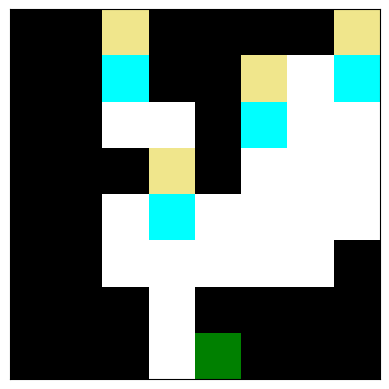

In [96]:
viz.plot_mini_sokoban(state_clean["real_states"][0])

In [61]:
def make_run_patched_drcnet(drc_net, patch_dict, tar_loc, env_out, rnn_state):
    def run_patched_drcnet(patch_activs):
        mode = "cell"
        patch_net = ActPatchDRCNet(drc_net)
        patch_action, patch_action_probs, patch_logits, patch_rnn_state = patch_net.forward_patch(env_out, rnn_state, activ_type=mode,
                                                                            patch_dict=patch_dict, activs=patch_activs)
        return patch_rnn_state[-1][:,1,tar_loc[0],tar_loc[1]]
    return run_patched_drcnet

In [62]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
envname = f"compare_cutoffpush_0"

all_channel_results = torch.zeros((64,))
all_tar_results = 0
all_box_results = 0
all_alttar_results = 0
all_altbox_results = 0
all_path1_results = 0
all_path2_results = 0

num_levels = len(os.listdir(f"../sokoban/gym_sokoban/envs/boxoban-levels/experiments/cutoffpush"))
env_info_df = pd.read_csv("../sokoban/gym_sokoban/envs/exp-levels-txt/cutoffpush.csv", index_col=0)

####
for i in range(0,num_levels,1):

    print(f"====== Level {i:04} ======")

    tar_loc = ast.literal_eval(env_info_df[f"cutoffpush_{i:04}"]["tar_loc"])
    box_loc = ast.literal_eval(env_info_df[f"cutoffpush_{i:04}"]["box_loc"])
    alttar_loc = ast.literal_eval(env_info_df[f"cutoffpush_{i:04}"]["alttar_loc"])
    altbox_loc = ast.literal_eval(env_info_df[f"cutoffpush_{i:04}"]["altbox_loc"])
    path1_loc = ast.literal_eval(env_info_df[f"cutoffpush_{i:04}"]["path1_loc"])
    path2_loc = ast.literal_eval(env_info_df[f"cutoffpush_{i:04}"]["path2_loc"])

    env = thinker.make(
        f"Sokoban-cutoffpush_corrupt_{i:04}-v0", 
        env_n=env_n, 
        gpu=gpu,
        wrapper_type=1, 
        has_model=False, 
        train_model=False, 
        parallel=False, 
        save_flags=False,
        mini=mini_sokoban,
        mini_unqtar=mini_unqtar,
        mini_unqbox=mini_unqbox         
        ) 
    flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
    flags.mini = mini_sokoban
    flags.mini_unqbtar = mini_unqtar
    flags.mini_unqbox = mini_unqbox
    drc_net = DRCNet(
        obs_space=env.observation_space,
        action_space=env.action_space,
        flags=flags,
        record_state=True,
        )
    drc_net.to(env.device)

    ckp_path = "../drc_mini"
    ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
    ckp = torch.load(ckp_path, env.device)
    drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
    rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
    state = env.reset()
    env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
    #actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
    state_corrupt = state

    _, _ = drc_net(env_out, rnn_state, greedy=True)
    layer2_tick1 = drc_net.hidden_state[:,2,160:192,:,:].clone().detach()
    layer1_tick2 = drc_net.hidden_state[:,3,96:128,:,:].clone().detach()

    env = thinker.make(
        f"Sokoban-cutoffpush_clean_{i:04}-v0", 
        env_n=env_n, 
        gpu=gpu,
        wrapper_type=1, 
        has_model=False, 
        train_model=False, 
        parallel=False, 
        save_flags=False,
        mini=mini_sokoban,
        mini_unqtar=mini_unqtar,
        mini_unqbox=mini_unqbox         
        ) 
    flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
    flags.mini = mini_sokoban
    flags.mini_unqbtar = mini_unqtar
    flags.mini_unqbox = mini_unqbox
    drc_net = DRCNet(
        obs_space=env.observation_space,
        action_space=env.action_space,
        flags=flags,
        record_state=True,
        )
    drc_net.to(env.device)

    ckp_path = "../drc_mini"
    ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
    ckp = torch.load(ckp_path, env.device)
    drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
    rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
    state = env.reset()
    env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
    state_clean = state

    patch_activs = drc_net.hidden_state[:,1:,:,:,:].clone().detach()
    patch_activs[:,1,160:192,:,:] = layer2_tick1
    patch_activs[:,2,96:128,:,:] = layer1_tick2

    patch_dict = {0: ([],[]), 1: ([2], list(range(32))), 2: ([1], list(range(32)))}

    run_patched_drcnet = make_run_patched_drcnet(drc_net=drc_net, patch_dict=patch_dict, tar_loc=path1_loc, env_out=env_out, rnn_state=rnn_state)

    intgrad = IntegratedGradients(run_patched_drcnet)
    attr_results = intgrad.attribute(inputs=drc_net.hidden_state[:,1:,:,:,:].clone().detach(), baselines=patch_activs, n_steps=200)
    print(f"Int. grad effect: ", attr_results.sum().item())
    key_results = torch.cat((attr_results[0,2,96:128,:,:], attr_results[0,1,160:192,:,:]), dim=0)

    attr_by_square = key_results.sum(dim=0)
    attr_by_channel = key_results.sum(dim=(1,2))

    all_channel_results += attr_by_channel
    all_tar_results += key_results[:,tar_loc[0], tar_loc[1]].sum().item()
    all_box_results += key_results[:,box_loc[0], box_loc[1]].sum().item()
    all_alttar_results += key_results[:,alttar_loc[0], alttar_loc[1]].sum().item()
    all_altbox_results += key_results[:,altbox_loc[0], altbox_loc[1]].sum().item()
    all_path1_results += key_results[:,path1_loc[0], path1_loc[1]].sum().item()
    all_path2_results += key_results[:,path2_loc[0], path2_loc[1]].sum().item()

all_channel_results /= num_levels
all_tar_results /= num_levels
all_box_results /= num_levels
all_alttar_results /= num_levels
all_altbox_results /= num_levels
all_path1_results /= num_levels
all_path2_results /= num_levels

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


====== Level 0000 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9660587417809552
====== Level 0001 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1001343914461956
====== Level 0002 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.300542440429178
====== Level 0003 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9392619886367901
====== Level 0004 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0709668461639863
====== Level 0005 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9489441334863555
====== Level 0006 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.262558746828729
====== Level 0007 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.128280830903056
====== Level 0008 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8918486391960414
====== Level 0009 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.889933212941163
====== Level 0010 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.80434850228859
====== Level 0011 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7822750298385999
====== Level 0012 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0139504047977494
====== Level 0013 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8137787385551065
====== Level 0014 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0037400426120957
====== Level 0015 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7238289723388964
====== Level 0016 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6094168590720144
====== Level 0017 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.721863779529337
====== Level 0018 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0045865800268983
====== Level 0019 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7265903832729748
====== Level 0020 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9294566360763175
====== Level 0021 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.816644233085861
====== Level 0022 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7658243245871124
====== Level 0023 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9051447575557812
====== Level 0024 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.972629768718941
====== Level 0025 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.2161769300731544
====== Level 0026 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.89559078221078
====== Level 0027 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9925674499507593
====== Level 0028 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.2466406954261915
====== Level 0029 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1350720904784803
====== Level 0030 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.211717055888332
====== Level 0031 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9458593363397705
====== Level 0032 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.068639599030354
====== Level 0033 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9329071415731562
====== Level 0034 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.2566907265255782
====== Level 0035 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8119540444430684
====== Level 0036 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0254031512482724
====== Level 0037 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.109029282569195
====== Level 0038 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1643483964671986
====== Level 0039 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0770939755316005
====== Level 0040 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8952225555202034
====== Level 0041 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.141990174817764
====== Level 0042 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8338694581519301
====== Level 0043 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9221156667569967
====== Level 0044 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.105437441115467
====== Level 0045 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.132776958881158
====== Level 0046 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9987877746621012
====== Level 0047 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.857658994333687
====== Level 0048 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.891173564580829
====== Level 0049 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.875162341513697
====== Level 0050 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.024923279547532
====== Level 0051 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.965511888262021
====== Level 0052 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9836940451642155
====== Level 0053 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1236407115481235
====== Level 0054 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.059362921689466
====== Level 0055 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8261680591728895
====== Level 0056 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7323941272023395
====== Level 0057 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7049393035144713
====== Level 0058 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.016727921633634
====== Level 0059 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6688716580827636
====== Level 0060 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0286944780767526
====== Level 0061 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7818769784922253
====== Level 0062 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7318162269197717
====== Level 0063 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8303293522469215
====== Level 0064 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.951590431592622
====== Level 0065 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8663967859101054
====== Level 0066 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.5518099907715905
====== Level 0067 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7386593221522506
====== Level 0068 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.536069070941492
====== Level 0069 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6051389023186322
====== Level 0070 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1731287002434954
====== Level 0071 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8079218390179197
====== Level 0072 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.2042030476827303
====== Level 0073 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7574508705299305
====== Level 0074 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.564589435991477
====== Level 0075 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9496531009547409
====== Level 0076 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7415665499301207
====== Level 0077 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6601105142571504
====== Level 0078 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.070302546702177
====== Level 0079 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7860421465131364
====== Level 0080 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6544640862860134
====== Level 0081 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6132982307201467
====== Level 0082 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9895398818126722
====== Level 0083 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7105182312383367
====== Level 0084 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.97772755116178
====== Level 0085 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7813770235649036
====== Level 0086 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6091611028488944
====== Level 0087 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7625532972590547
====== Level 0088 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.2577900256415058
====== Level 0089 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8992094739849135
====== Level 0090 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0940419691404846
====== Level 0091 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.610290423321983
====== Level 0092 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9172534954628733
====== Level 0093 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7189300057929833
====== Level 0094 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.580950602867457
====== Level 0095 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.5766924362398607
====== Level 0096 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0793576738458968
====== Level 0097 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1383877368139577
====== Level 0098 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9227720046437589
====== Level 0099 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.07528610351572
====== Level 0100 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.094266313282515
====== Level 0101 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.103735844850891
====== Level 0102 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.291566209811262
====== Level 0103 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.004201914322043
====== Level 0104 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9250140652882826
====== Level 0105 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1220903922559207
====== Level 0106 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8655371782306007
====== Level 0107 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9769989866680788
====== Level 0108 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1645356740048585
====== Level 0109 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0683931964246876
====== Level 0110 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.111764368893508
====== Level 0111 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8883820030452354
====== Level 0112 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8746690674558886
====== Level 0113 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.993527397509578
====== Level 0114 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7922295116506564
====== Level 0115 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9419313398680076
====== Level 0116 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.101592907585551
====== Level 0117 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0418089015176335
====== Level 0118 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1217473431990412
====== Level 0119 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7750428961572149
====== Level 0120 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7591354580776302
====== Level 0121 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7381916132454955
====== Level 0122 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0440325255994902
====== Level 0123 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6438241899000063
====== Level 0124 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9662971088676375
====== Level 0125 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7840548170401378
====== Level 0126 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7713623809909391
====== Level 0127 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.912722729018783
====== Level 0128 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.5979751135608211
====== Level 0129 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6256743071170743
====== Level 0130 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1327649018258175
====== Level 0131 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.5634385822041352
====== Level 0132 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8199141074956877
====== Level 0133 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7827096754358216
====== Level 0134 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7721258044821864
====== Level 0135 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7999581085274736
====== Level 0136 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6239583771862207
====== Level 0137 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6777909917317708
====== Level 0138 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0150047780582745
====== Level 0139 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6467946712692592
====== Level 0140 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.92638977324324
====== Level 0141 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7127165045191
====== Level 0142 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7516210885918673
====== Level 0143 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8769917422548474
====== Level 0144 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.1524621276341738
====== Level 0145 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.635788797626713
====== Level 0146 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.354525841521834
====== Level 0147 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.5125881485576387
====== Level 0148 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1416555875642675
====== Level 0149 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7386306007242056
====== Level 0150 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7255439176113143
====== Level 0151 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.774365302497914
====== Level 0152 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8849791959090407
====== Level 0153 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.074322125847914
====== Level 0154 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8223433381512404
====== Level 0155 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8789001409164414
====== Level 0156 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0550820922035937
====== Level 0157 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9968732858414906
====== Level 0158 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1950570157682048
====== Level 0159 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8801629169180154
====== Level 0160 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8497070859264466
====== Level 0161 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.103981872243465
====== Level 0162 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8357267841267
====== Level 0163 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8961630821929225
====== Level 0164 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1016888242172644
====== Level 0165 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1296548250394283
====== Level 0166 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.144058122533469
====== Level 0167 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8942087653382345
====== Level 0168 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.5351785492724204
====== Level 0169 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.62679802789945
====== Level 0170 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.049198252088687
====== Level 0171 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.637303527864474
====== Level 0172 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8005431551862208
====== Level 0173 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.759126311427804
====== Level 0174 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.5780286422603864
====== Level 0175 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7288466551525334
====== Level 0176 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7082357440165348
====== Level 0177 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.705753972339369
====== Level 0178 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0725652746654286
====== Level 0179 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8618383020101599
====== Level 0180 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.113965756499492
====== Level 0181 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8524615437196057
====== Level 0182 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.642608890931623
====== Level 0183 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0036536616537464
====== Level 0184 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8626053735693597
====== Level 0185 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.808639322880881
====== Level 0186 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.5962187057966775
====== Level 0187 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8793188822992486
====== Level 0188 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.718248814400097
====== Level 0189 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.5530890335504033
====== Level 0190 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8824444050032836
====== Level 0191 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6493803453907665
====== Level 0192 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.913856958763004
====== Level 0193 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8312931006520248
====== Level 0194 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6248550718834605
====== Level 0195 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8225108951379312
====== Level 0196 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7288336256275385
====== Level 0197 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.5960839337726287
====== Level 0198 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0343996153452046
====== Level 0199 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7206567259046415
====== Level 0200 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.039745593712091
====== Level 0201 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7420118242664338
====== Level 0202 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8770349720704285
====== Level 0203 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.7467330963719465
====== Level 0204 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.4823537777431224
====== Level 0205 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.511283052359128
====== Level 0206 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.155354707886874
====== Level 0207 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.6813666384687882
====== Level 0208 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -0.24476855555134394
====== Level 0209 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -0.13886506190195896
====== Level 0210 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -0.07867557437768162
====== Level 0211 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -0.4430235027229951
====== Level 0212 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -0.03967024394424646
====== Level 0213 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -0.11288716743640387
====== Level 0214 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -0.409580909934559
====== Level 0215 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  0.09423950447519286
====== Level 0216 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.8792461788887258
====== Level 0217 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0260337939915023
====== Level 0218 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0761829302790935
====== Level 0219 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9354221506405649
====== Level 0220 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.049309981665257
====== Level 0221 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0718465637630987
====== Level 0222 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0328904820713376
====== Level 0223 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.001641028813601
====== Level 0224 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9379064916839068
====== Level 0225 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9377448705092826
====== Level 0226 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.1302082834161915
====== Level 0227 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9702675043292581
====== Level 0228 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0361930287531216
====== Level 0229 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.991665652679396
====== Level 0230 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.0789796334668935
====== Level 0231 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9310701895442952
====== Level 0232 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9330413020872828
====== Level 0233 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.960798667644584
====== Level 0234 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.019331598346974
====== Level 0235 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.915118137393841
====== Level 0236 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.080957378080636
====== Level 0237 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -2.025136317677642
====== Level 0238 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9562826813759138
====== Level 0239 ======


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Int. grad effect:  -1.9960846226344715


/tmp/ipykernel_1706/2953125311.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([f"L1C{c}" for c in range(32)] + [f"L2C{c}" for c in range(32)], rotation="vertical")


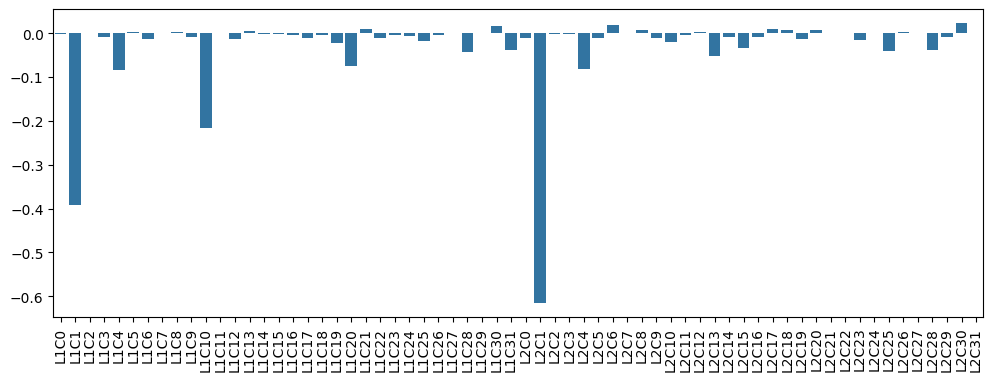

In [63]:
fig, axs = plt.subplots(1,1, figsize=(12,4))
sns.barplot(all_channel_results, ax=axs)
axs.set_xticklabels([f"L1C{c}" for c in range(32)] + [f"L2C{c}" for c in range(32)], rotation="vertical")
plt.show()

/tmp/ipykernel_1706/1726530997.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(["tar", "box", "alttar", "altbox", "path1", "path2"], rotation="vertical")


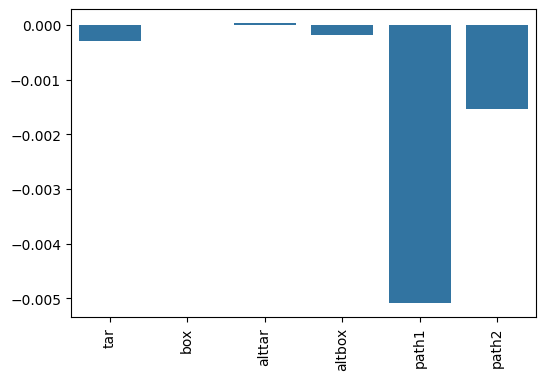

In [65]:
fig, axs = plt.subplots(1,1, figsize=(6,4))
sns.barplot(torch.tensor([all_tar_results, all_box_results, all_alttar_results, all_altbox_results, all_path1_results, all_path2_results])/num_levels, ax=axs)
axs.set_xticklabels(["tar", "box", "alttar", "altbox", "path1", "path2"], rotation="vertical")
plt.show()

In [98]:
from captum.attr import IntegratedGradients

In [105]:
patch_activs = drc_net.hidden_state[:,1:,:,:,:].clone().detach()
patch_activs[:,1,160:192,:,:] = layer2_tick1
patch_activs[:,2,96:128,:,:] = layer1_tick2

In [100]:
patch_activs.shape, layer1_tick2.shape

(torch.Size([1, 3, 224, 8, 8]), torch.Size([1, 32, 8, 8]))

In [106]:
intgrad = IntegratedGradients(run_patched_drcnet)
attr_results = intgrad.attribute(inputs=drc_net.hidden_state[:,1:,:,:,:].clone().detach(), baselines=patch_activs, n_steps=200)

----- patching activations for tick 1 ---- 
--- NOT patching layer 0 ---
--- NOT patching layer 1 ---
--- Patching Layer 2 ---
patching channels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] in cell
----- patching activations for tick 2 ---- 
--- NOT patching layer 0 ---
--- Patching Layer 1 ---
patching channels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] in cell
--- NOT patching layer 2 ---


In [107]:
attr_results.sum()

tensor(2.2706, dtype=torch.float64)

In [86]:
attr_results.sum()

tensor(1.9507, dtype=torch.float64)

In [13]:
channels = [1,9]

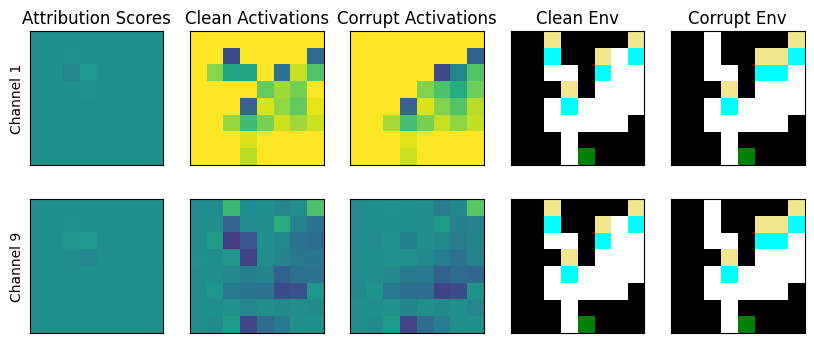

In [108]:
channels = [1,9]
fig, axs = plt.subplots(len(channels),5, figsize=(10,2*len(channels)))

state_c = state_clean["real_states"][0].permute(1,2,0)
dim_z = 7
mini_board = np.zeros(state_c.shape[:-1])
for i in range(1,1+dim_z):
    mini_board[(state_c[:,:,i-1] == 1)] = i
mini_board_c = np.flip(mini_board, axis=0)
cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
bounds= [i+0.5 for i in range(1+dim_z)]
norm = colors.BoundaryNorm(bounds, cmap.N)

state_co = state_corrupt["real_states"][0].permute(1,2,0)
dim_z = 7
mini_board = np.zeros(state_co.shape[:-1])
for i in range(1,1+dim_z):
    mini_board[(state_co[:,:,i-1] == 1)] = i
mini_board_co = np.flip(mini_board, axis=0)
cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
bounds= [i+0.5 for i in range(1+dim_z)]
norm = colors.BoundaryNorm(bounds, cmap.N)

for i in range(len(channels)):
    axs[i][0].imshow(attr_results[0,1,160+channels[i],:,:].detach(), vmin=-0.3, vmax=0.3)
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].imshow(drc_net.hidden_state[0,2,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][0].set_ylabel(f"Channel {channels[i]}")
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])
    axs[i][2].imshow(patch_activs[0,1,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][2].set_xticks([])
    axs[i][2].set_yticks([])
    board_img = axs[i][3].imshow(mini_board_c, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)
    board_img = axs[i][4].imshow(mini_board_co, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)

axs[0][0].set_title("Attribution Scores")
axs[0][1].set_title("Clean Activations")
axs[0][2].set_title("Corrupt Activations")
axs[0][3].set_title("Clean Env")
axs[0][4].set_title("Corrupt Env")
plt.show()

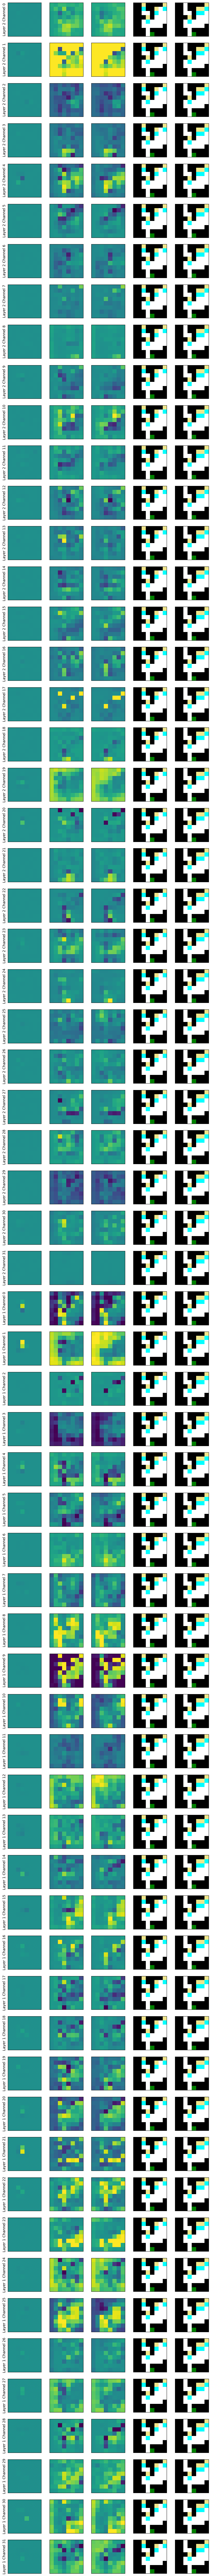

In [110]:
channels = list(range(32))
fig, axs = plt.subplots(2*len(channels),5, figsize=(10,4*len(channels)))

state_c = state_clean["real_states"][0].permute(1,2,0)
dim_z = 7
mini_board = np.zeros(state_c.shape[:-1])
for i in range(1,1+dim_z):
    mini_board[(state_c[:,:,i-1] == 1)] = i
mini_board_c = np.flip(mini_board, axis=0)
cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
bounds= [i+0.5 for i in range(1+dim_z)]
norm = colors.BoundaryNorm(bounds, cmap.N)

state_co = state_corrupt["real_states"][0].permute(1,2,0)
dim_z = 7
mini_board = np.zeros(state_co.shape[:-1])
for i in range(1,1+dim_z):
    mini_board[(state_co[:,:,i-1] == 1)] = i
mini_board_co = np.flip(mini_board, axis=0)
cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
bounds= [i+0.5 for i in range(1+dim_z)]
norm = colors.BoundaryNorm(bounds, cmap.N)

for i in range(len(channels)):
    axs[i][0].imshow(attr_results[0,1,160+channels[i],:,:].detach(), vmin=-0.3, vmax=0.3)
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].imshow(drc_net.hidden_state[0,2,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][0].set_ylabel(f"Layer 2 Channel {channels[i]}")
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])
    axs[i][2].imshow(patch_activs[0,1,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][2].set_xticks([])
    axs[i][2].set_yticks([])
    board_img = axs[i][3].imshow(mini_board_c, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)
    board_img = axs[i][4].imshow(mini_board_co, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)

for i in range(len(channels)):
    axs[i+len(channels)][0].imshow(attr_results[0,2,96+channels[i],:,:].detach(), vmin=-0.3, vmax=0.3)
    axs[i+len(channels)][0].set_xticks([])
    axs[i+len(channels)][0].set_yticks([])
    axs[i+len(channels)][1].imshow(drc_net.hidden_state[0,3,96+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i+len(channels)][0].set_ylabel(f"Layer 1 Channel {channels[i]}")
    axs[i+len(channels)][1].set_xticks([])
    axs[i+len(channels)][1].set_yticks([])
    axs[i+len(channels)][2].imshow(patch_activs[0,2,96+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i+len(channels)][2].set_xticks([])
    axs[i+len(channels)][2].set_yticks([])
    board_img = axs[i+len(channels)][3].imshow(mini_board_c, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)
    board_img = axs[i+len(channels)][4].imshow(mini_board_co, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)
plt.show()

In [111]:
key_results = attr_results[0,].shape

torch.Size([1, 3, 224, 8, 8])

In [132]:
key_results = torch.cat((attr_results[0,2,96:128,:,:], attr_results[0,1,160:192,:,:]), dim=0)

In [141]:
attr_by_square = key_results.sum(dim=0)
attr_by_channel = key_results.sum(dim=(1,2))

/tmp/ipykernel_1659/2953125311.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([f"L1C{c}" for c in range(32)] + [f"L2C{c}" for c in range(32)], rotation="vertical")


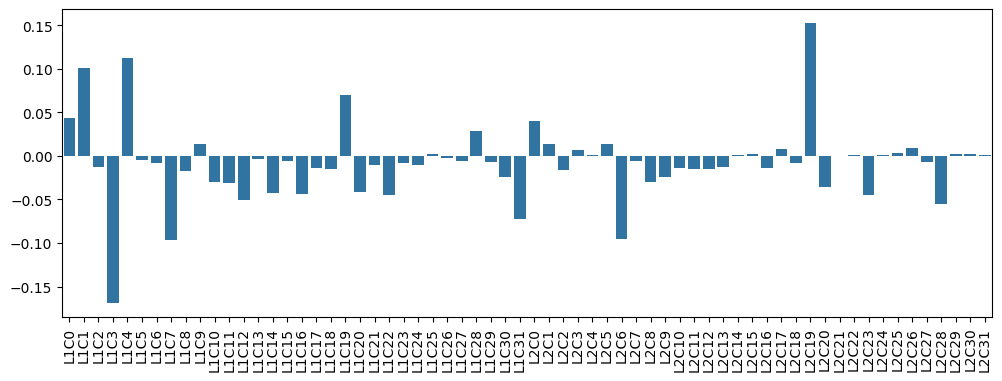

In [11]:
fig, axs = plt.subplots(1,1, figsize=(12,4))
sns.barplot(all_channel_results, ax=axs)
axs.set_xticklabels([f"L1C{c}" for c in range(32)] + [f"L2C{c}" for c in range(32)], rotation="vertical")
plt.show()

/tmp/ipykernel_1659/2084538476.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(["tar", "box", "alttar", "altbox", "path1", "path2"], rotation="vertical")


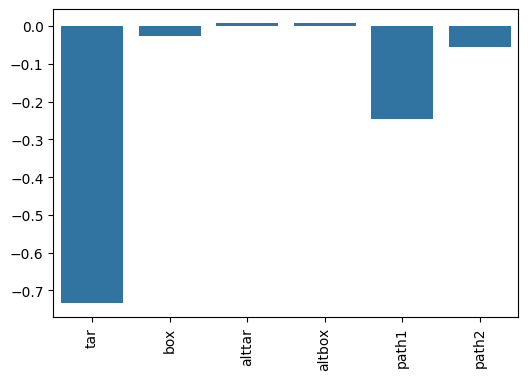

In [8]:
fig, axs = plt.subplots(1,1, figsize=(6,4))
sns.barplot(torch.tensor([all_tar_results, all_box_results, all_alttar_results, all_altbox_results, all_path1_results, all_path2_results])/30, ax=axs)
axs.set_xticklabels(["tar", "box", "alttar", "altbox", "path1", "path2"], rotation="vertical")
plt.show()

<BarContainer object of 64 artists>

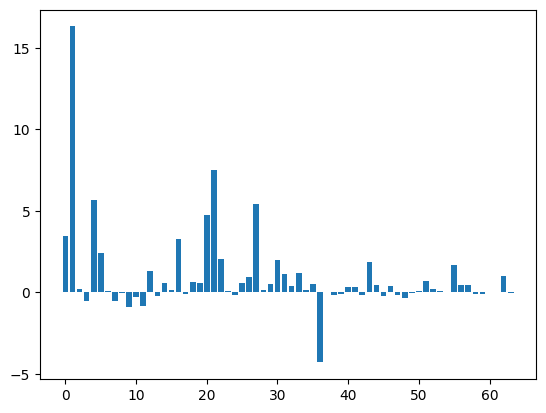

In [166]:
plt.bar(x=range(64), height=all_channel_results)

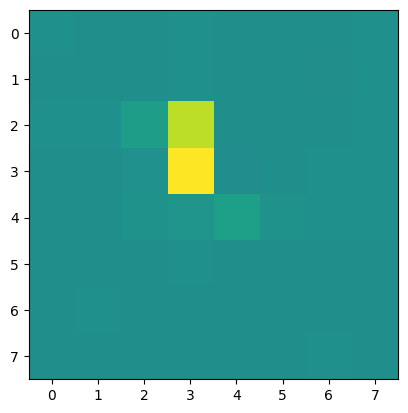

In [145]:
plt.imshow(attr_by_square, vmin=-1, vmax=1)

In [129]:
torch.tensor([[-1,1,2,-3],[-1,-4,5,3]]).sum(dim=0, keepdim=True)

tensor([[-2, -3,  7,  0]])